# Where to open a new coffee shop?

In [14]:
!pip install rtree

In [15]:
import pandas as pd
import geopandas as gpd
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
denver = pd.read_csv('./data/denver.csv')
neighborhoods = gpd.read_file('./data/neighborhoods.shp')
census = pd.read_csv('./data/census.csv')

In [16]:
# Denver location dataset ----------------------------------------------
neighborhoods.crs = "EPSG:4326"
neighborhoods_3857 = neighborhoods.to_crs(epsg = 3857)
neighborhoods['area'] = neighborhoods_3857.geometry.area/10 ** 6

# Census missing data imputation
imp = IterativeImputer(max_iter=10, random_state=0)
census_imp = census.drop(columns = ['NBHD_ID', 'NBHD_NAME'])
census_imp = pd.DataFrame(imp.fit_transform(census_imp), columns = census_imp.columns)
census_imp.loc[census_imp['NUM_HHLD_100K+']<0, 'NUM_HHLD_100K+'] = 0
census_imp.loc[census_imp['NUM_HOUSEHOLDS'] <= census_imp['NUM_HHLD_100K+'], 'NUM_HHLD_100K+'] = 0
census_imp['NUM_HOUSEHOLDS'] <= census_imp['NUM_HHLD_100K+']

for col in census_imp.columns:
    census_imp[col] = census_imp[col].astype('int')
    
census_imputed = census[['NBHD_ID', 'NBHD_NAME']].join(census_imp)

---

In [17]:
# Data transformation ----------------------------------------------
census_neighbors = neighborhoods.merge(census_imputed, on='NBHD_NAME')
census_neighbors.drop(columns=['NBHD_ID_y'], inplace=True)
census_neighbors.rename(columns = {'NBHD_ID_x':'NBHD_ID'}, inplace=True)
census_neighbors['AGE_LESS_18_prop'] =census_neighbors['AGE_LESS_18'] / census_neighbors['POPULATION_2010']
census_neighbors['AGE_18_TO_34_prop'] =census_neighbors['AGE_18_TO_34'] / census_neighbors['POPULATION_2010']
census_neighbors['AGE_35_TO_65_prop'] =census_neighbors['AGE_35_TO_65'] / census_neighbors['POPULATION_2010']
census_neighbors['AGE_65_PLUS_prop'] =census_neighbors['AGE_65_PLUS'] / census_neighbors['POPULATION_2010']
#census_neighbors['NUM_HHLD_100K+'].fillna(0,inplace=True)
census_neighbors['NUM_HHLD_100K_prop'] = census_neighbors['NUM_HHLD_100K+'] / census_neighbors['NUM_HOUSEHOLDS']
census_neighbors['density'] = census_neighbors['POPULATION_2010'] / census_neighbors['area'] 

census_neighbors['density_scaled'] = \
    (census_neighbors['density'] - census_neighbors['density'].min())/\
    (census_neighbors['density'].max() - census_neighbors['density'].min())

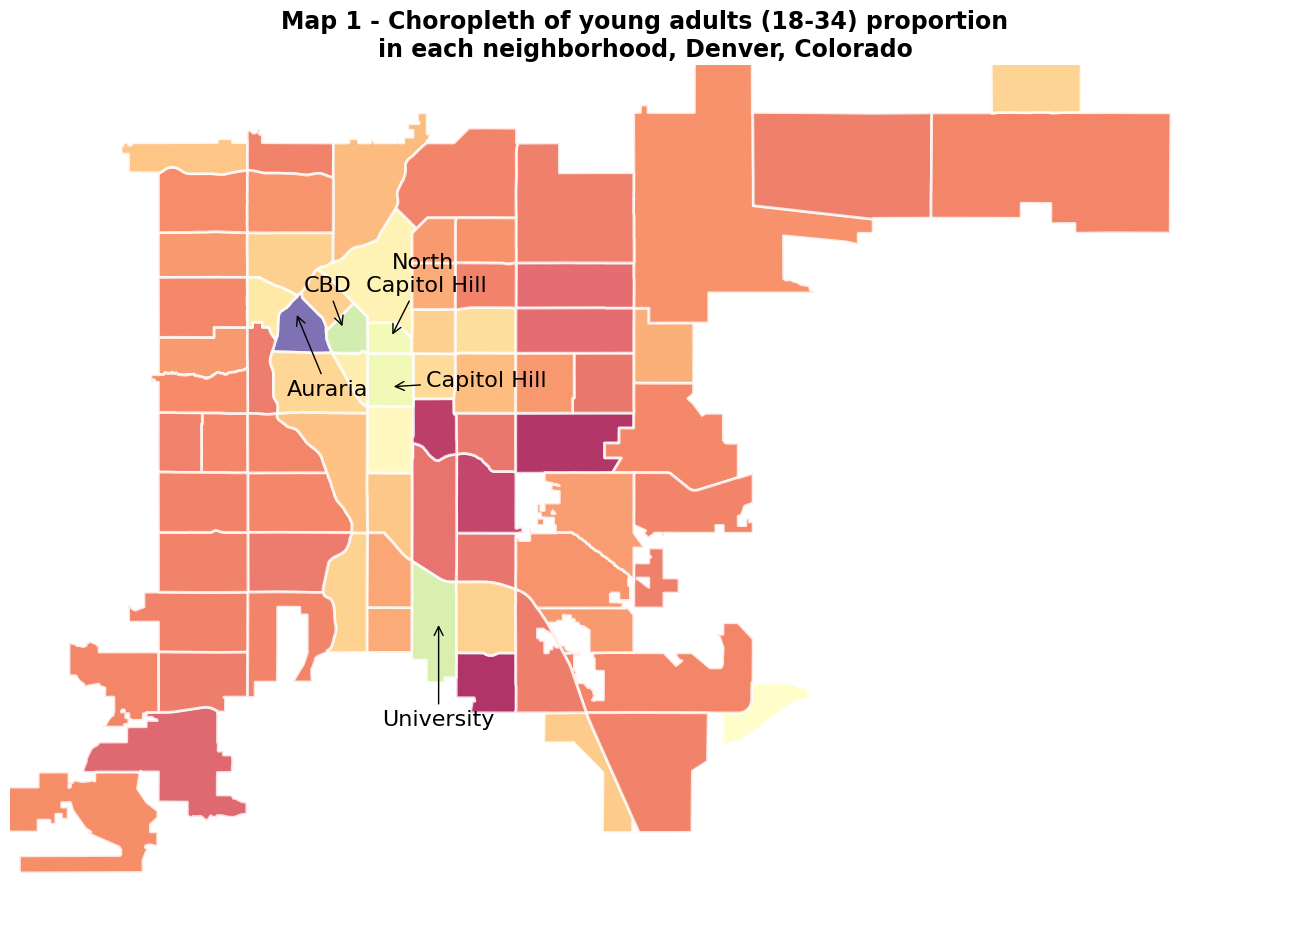

In [18]:
# First map
fig, ax= plt.subplots(1,1, figsize=(13, 13))

plt.title('Map 1 - Choropleth of young adults (18-34) proportion\nin each neighborhood, Denver, Colorado', size=17, weight='heavy')
census_neighbors.plot(column='AGE_18_TO_34_prop', cmap='Spectral',
                      edgecolor='white',linewidth=2, ax=ax, alpha=0.8)

def plot_annotate(name, xy, xytext, color='black'):
    ax.annotate(text=name, xy=xy, xytext=xytext, size=16, arrowprops=dict(arrowstyle="->", color=color), 
                horizontalalignment='center', color=color)
    
plot_annotate('Auraria', (-105.01, 39.75), (-105, 39.73))
plot_annotate('University', (-104.965, 39.675), (-104.965, 39.65))
plot_annotate('CBD', (-104.995, 39.746), (-105, 39.755))
plot_annotate('Capitol Hill', (-104.98, 39.732), (-104.95, 39.732))
plot_annotate('North\n Capitol Hill', (-104.98, 39.744), (-104.97, 39.755))

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.xlim([-105.1,-104.7])
plt.ylim([39.6,39.81])
plt.axis('off')
plt.tight_layout()

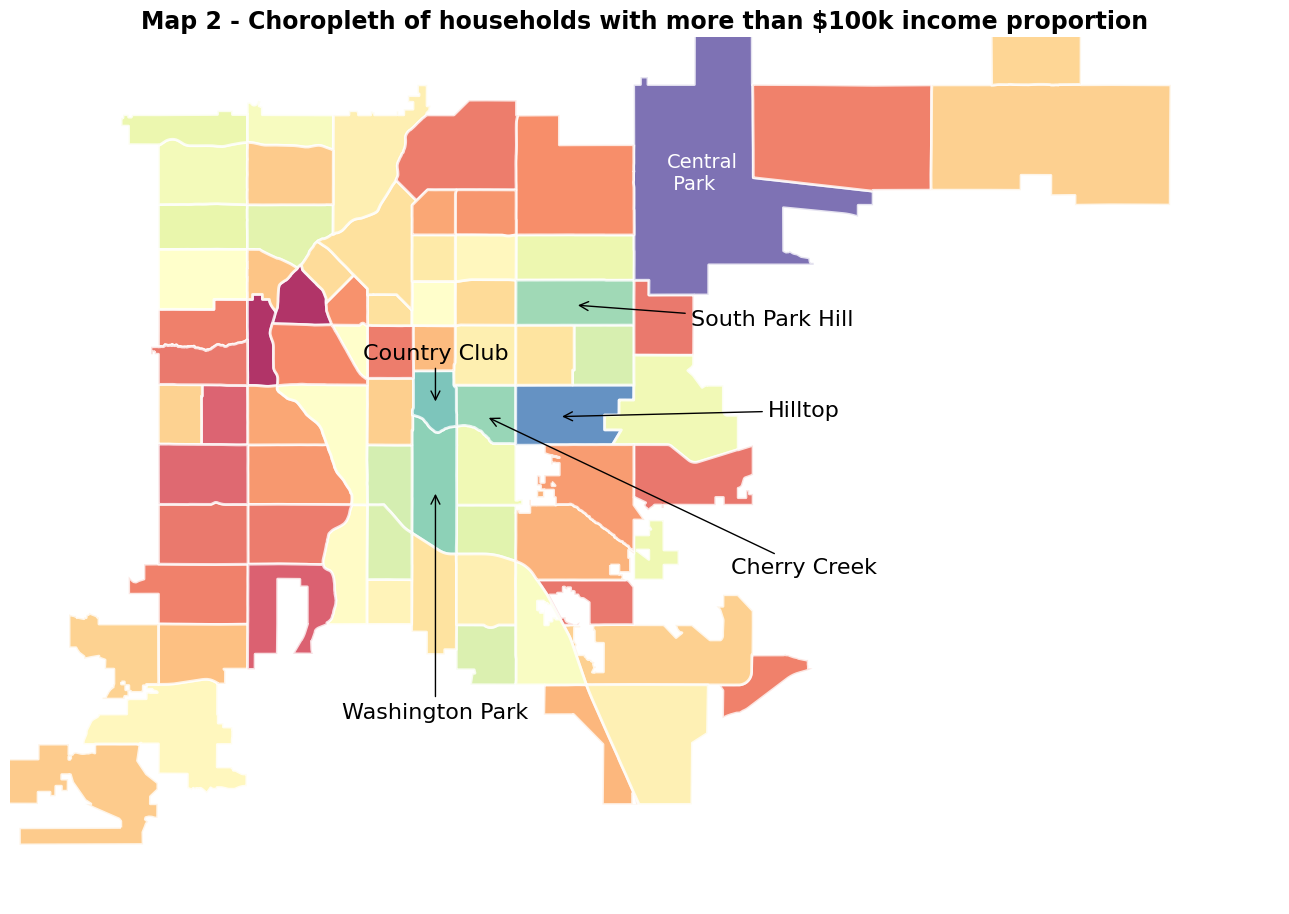

In [19]:
# Second map
fig, ax= plt.subplots(1,1, figsize=(13, 13))
plt.title('Map 2 - Choropleth of households with more than $100k income proportion', size=17, weight='heavy')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None) 
census_neighbors.plot(column='NUM_HHLD_100K_prop', cmap='Spectral',
                      edgecolor='white',linewidth=2, ax=ax, alpha=0.8)


plot_annotate('Hilltop', (-104.927, 39.718), (-104.85, 39.718))
plot_annotate('Washington Park', (-104.966, 39.70), (-104.966, 39.645))
plot_annotate('Cherry Creek', (-104.95, 39.718), (-104.85, 39.68))
plot_annotate('Country Club', (-104.966, 39.721), (-104.966, 39.732))
plot_annotate('South Park Hill', (-104.922, 39.745), (-104.86, 39.74))

plt.text(s='Central\n Park', x=-104.893, y=39.773, size=14, color='white')

plt.xlim([-105.1,-104.7])
plt.ylim([39.6,39.81])

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.axis('off')
plt.tight_layout()

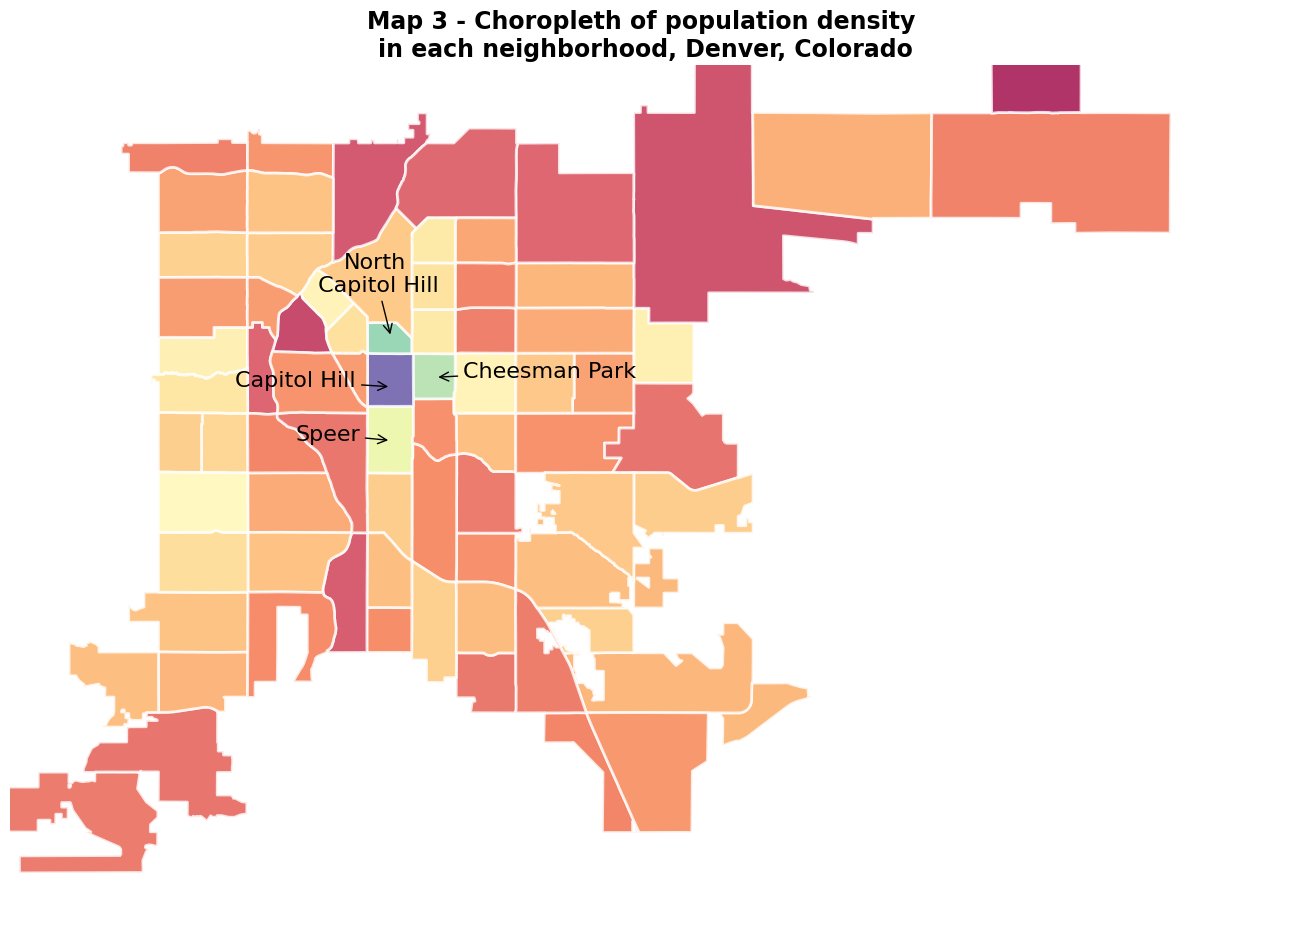

In [20]:
fig, ax= plt.subplots(1,1, figsize=(13, 13))

census_neighbors.plot(column='density', cmap='Spectral', 
                      edgecolor='white',linewidth=2, ax=ax, alpha=0.8)
plt.title('Map 3 - Choropleth of population density \nin each neighborhood, Denver, Colorado', size=17, weight='heavy')
plot_annotate('Capitol Hill', (-104.98, 39.732), (-105.01, 39.732))
plot_annotate('North\n Capitol Hill', (-104.98, 39.744), (-104.985, 39.755))
plot_annotate('Cheesman Park', (-104.966, 39.7343), (-104.93, 39.7343))
plot_annotate('Speer', (-104.98, 39.719), (-105, 39.719))

plt.xlim([-105.1,-104.7])
plt.ylim([39.6,39.81])
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.axis('off')
plt.tight_layout()

In [22]:
denver_gpd = gpd.GeoDataFrame(
    denver, geometry=gpd.points_from_xy(denver['Longitude'], denver['Latitude']))

denver_gpd['geometry'] = denver_gpd.geometry.buffer(0.00001)
denver_gpd.crs = "EPSG:4326"
denver_4326 = denver_gpd.to_crs(epsg = 4326)

denver_neighbors = neighborhoods.merge(denver_4326, how='left') 
denver_neighbors.dropna(subset=['Longitude'], inplace=True)

C:\Users\swell\AppData\Local\Temp\ipykernel_11948\2939536291.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  denver_gpd['geometry'] = denver_gpd.geometry.buffer(0.00001)


In [23]:
starbucks_density = denver_neighbors['NBHD_NAME'].value_counts().to_frame().reset_index()
starbucks_density.columns = ['NBHD_NAME', 'Count']
neighborhoods_density = neighborhoods.merge(starbucks_density, on='NBHD_NAME')

fig, ax= plt.subplots(1,1, figsize=(13, 13))
plt.title('Map 4 - Choropleth of Starbucks branch locations \nin each neighborhood, Denver, Colorado',
          size=17, weight='heavy')

# Background map -------------------------------------------------
neighborhoods.plot(column ='NBHD_NAME', color='whitesmoke', edgecolor='gray', 
                       linestyle=':', ax=ax)
# Foreground map -------------------------------------------------
neighborhoods_density.plot(column='Count', cmap='Spectral', edgecolor='black', linewidth=1.5, ax=ax,
                          alpha = 0.8)

# Annotations  -------------------------------------------------
def plot_annotate(name, xy, xytext):
    ax.annotate(text=name, xy=xy, xytext=xytext, size=13, arrowprops=dict(arrowstyle="->"), 
                horizontalalignment='center', color='black')
    
plot_annotate('CBD', (-104.993, 39.745), (-104.985, 39.76)) # 1
plot_annotate('Civic Center', (-104.987, 39.735), (-105.1, 39.7)) # 2
plot_annotate('Union Station', (-105, 39.75), (-105.02, 39.8)) # 3
plot_annotate('Central \nPark', (-104.885, 39.773), (-104.885, 39.771)) # 4
plot_annotate('Highland', (-105.01, 39.76), (-105.1, 39.76)) # 5
plot_annotate('University', (-104.965, 39.67), (-104.965, 39.65)) # 6
plot_annotate('Cherry Creek', (-104.95, 39.72), (-104.8, 39.72)) # 7 
plot_annotate('Cheesman Park', (-104.97, 39.73), (-104.94, 39.75)) # 8
plot_annotate('Lincoln Park', (-105, 39.735), (-105.1, 39.73)) # 9

# Axes ----------------------------------------------------
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
_ = plt.axis('off')

_ = plt.xlim([-105.15,-104.7])
_ = plt.ylim([39.6,39.835])

plt.tight_layout()

c:\Users\swell\OneDrive\Bureau\pythonista-data-science-ninja\venv\lib\site-packages\geopandas\plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
c:\Users\swell\OneDrive\Bureau\pythonista-data-science-ninja\venv\lib\site-packages\geopandas\plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


ValueError: cannot convert float NaN to integer

Error in callback <function _draw_all_if_interactive at 0x00000287298FBAC0> (for post_execute):


ValueError: cannot convert float NaN to integer

ValueError: cannot convert float NaN to integer

<Figure size 1300x1300 with 1 Axes>